In [50]:
# Run this cell only once then delete it, this just a relacement for running pip install olfpy
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
install('odfpy')
install('keras')

In [1]:
import scipy
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
def load_data_part1():
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    # Emission Data (CO2)
    EU_em_df = pd.read_excel('Data/Table_11.5_Carbon_Dioxide_Emissions_From_Energy_Consumption__Transportation_Sector.xlsx',engine='openpyxl')
    EU_em_annual_df = pd.read_csv('Data/EU_annual_carbon_emission_by_road_transportation.csv',)
    UK_em_df = pd.read_excel('Data/uk-env0201.ods', nrows = 16)
    US_em_df = pd.read_excel('Data/US_em.xlsx',engine='openpyxl')
        # Emissions data Processing
    EU_em_df = EU_em_df.set_index('Month')
    UK_em_df = UK_em_df.transpose()
    
    # Electric Vehicles
    EU_veh_df = pd.read_csv('Data/new-electric-vehicles-in-eu-1.csv')
    UK_veh_df = pd.read_excel('Data/veh0203.ods', nrows= 76)
    US_veh_df = pd.read_excel('Data/10354_epact_vehicle_history_5-21-21.xlsx',engine='openpyxl')
    return EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df,UK_veh_df, US_veh_df

EU_em_df, EU_em_annual_df, UK_em_df, US_em_df, EU_veh_df,UK_veh_df, US_veh_df = load_data_part1()

def load_data_part2():
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    # Secondary Data 
        # Air pollution
            # UK 1970-2019/2022
    UK_nox_annual_df = pd.read_csv('Data/Figure06_NOx_time_series.csv')
    UK_pm_all_annual_df = pd.read_csv('Data/Figure03_PM_time_series.csv')
            
            # USA Since 1970-2020, plz Access through column id(numbers)
    USA_nox_annual_df = pd.read_csv('Data/US_nox_em_time_series.csv') # National Emissions Totals (thousands of tons)
    USA_pm_10_annual_df = pd.read_csv('Data/US_pm10_year.csv')        #
    USA_pm_2_5_annual_df = pd.read_csv('Data/US_pm2_5_year.csv')
    
    USA_pm_2_5_annual_df = USA_pm_2_5_annual_df.transpose()
    USA_pm_10_annual_df = USA_pm_10_annual_df.transpose()
            
            # OCED DATA
    OCED_PM10_df = pd.read_excel('Data/PM10_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    OCED_NOX_df = pd.read_excel('Data/NOX_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    OCED_PM2_5_df = pd.read_excel('Data/PM2_5_ROAD_OCED_WORLD_DATA.xlsx',engine='openpyxl')
    
    return UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df
    
UK_nox_annual_df,UK_pm_all_annual_df,USA_pm_10_annual_df,USA_pm_2_5_annual_df,USA_nox_annual_df,OCED_PM10_df,OCED_NOX_df,OCED_PM2_5_df = load_data_part2()

# Eric: Simpler ways to read the data
# calling head() method  
# storing in new variable 
data_top = UK_em_df
    
# display 
data_top 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Emissions by type,Cars and taxis,Heavy goods vehicles,Light vans,Buses and coaches,Motorcycles & mopeds,Other road transport emissions3,Total,Rail4,Domestic aviation,Domestic shipping,Other5,Total,Total domestic transport,Net domestic emissions all sources,Transport as a % of Net Domestic Emissions,all sources
1990,72.288275,20.459582,11.635496,5.250419,0.772827,0.172806,110.579406,1.973766,1.499415,8.502533,5.580942,17.556656,128.136062,809.119904,0.158365,15.524836
1991,72.030035,19.443355,12.030185,5.380211,0.749343,0.173209,109.806338,1.997908,1.512703,8.402334,4.571358,16.484303,126.290641,817.691665,0.154448,15.264028
1992,73.603872,19.36742,12.165372,5.313245,0.639058,0.173819,111.262786,2.027496,1.513713,8.375398,4.375566,16.292172,127.554958,795.942404,0.160257,16.915626
1993,74.495858,19.642407,12.37022,5.300851,0.54123,0.174334,112.5249,1.970062,1.475062,8.525637,4.434566,16.405326,128.930226,775.78571,0.166193,18.142856
1994,73.900588,20.249144,12.894949,5.366889,0.527526,0.17828,113.117377,1.933608,1.364923,9.54319,4.261171,17.102892,130.220269,766.027618,0.169994,18.924046
1995,73.169682,19.911583,12.897726,5.440522,0.515092,0.181812,112.116418,2.00841,1.442489,9.956257,4.197132,17.604288,129.720706,759.278121,0.170847,20.135041
1996,75.927499,20.467865,13.533725,5.504577,0.534188,0.189653,116.157507,2.131531,1.625741,9.942154,4.128161,17.827587,133.985094,780.025681,0.17177,21.287108
1997,76.60942,20.502039,14.108357,5.503599,0.572142,0.196536,117.492093,2.1777,1.675697,9.614148,3.973541,17.441086,134.933179,753.503091,0.179074,22.651221
1998,75.848641,20.263323,14.361612,5.358297,0.588175,0.206116,116.626163,2.281007,1.797075,9.80499,3.553729,17.436801,134.062964,750.506747,0.17863,25.241458


In [3]:
# UK data
ElectricCars = UK_veh_df['Hybrid Electric 1'][:27]+UK_veh_df['Plug-in Hybrid Electric 2'][:27]+UK_veh_df['Battery Electric'][:27]+UK_veh_df['Range-Extended Electric 3'][:27]+UK_veh_df['Fuel Cell Electric 4'][:27]
electric_car_dat = np.array(ElectricCars[:-1]).reshape(-1,1)
road_emission_by_veh = np.array(UK_em_df[6][5:]).reshape(-1,1)

# USA data
US_em_df_transpose = US_em_df.transpose()
US_veh_df_transpose = US_veh_df.transpose()

us_car_emission = US_em_df_transpose[1][4:]+US_em_df_transpose[6][4:]+US_em_df_transpose[11][4:]+US_em_df_transpose[16][4:]+US_em_df_transpose[21][4:]
us_car_emission = np.array(us_car_emission)
us_car_emission = us_car_emission.reshape(-1,1)

us_electric_veh = US_veh_df_transpose[9][2:-1]
us_electric_veh = np.array(us_electric_veh)
us_electric_veh = us_electric_veh.reshape(-1,1)

In [4]:
def produce_predictions_linear_regression(train_X, train_y):
    # data fitting
    model = LinearRegression().fit(train_X, train_y)
    # make predictions
    regression = model.predict(train_X)
    return regression,model

In [5]:
def to_do_normal(dataset):
    # normalize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_dataset = scaler.fit_transform(dataset)
    normalized_dataset = normalized_dataset + 1 # avoid zeros
    return normalized_dataset

In [54]:
def data_transpose(xx):
    xx = xx.transpose()
    xx = xx[0]
    return xx

In [62]:
def mean_squared_percentage_error(y_true, y_pred): 
    MSPE = np.mean(mean_squared_error(y_true,y_pred,squared = True)/y_true) * 100
    return np.abs(MSPE)

In [53]:
def Rsqaured_test(predictions,true):
    abs_error = predictions - true
    R2 = 1.0 - (np.var(abs_error) / np.var(true))
    return R2

In [7]:
def func(x, a, b, o): # Sigmoid Function with an offset 
    y = 1 / (1 + np.exp(-a*(x-b))) + o
    return y

# function for genetic algorithm to minimize (sum of squared error)
def generate_Initial_Parameters(x,y):
    bounds = []
    bounds.append([min(x), max(x)]) #
    bounds.append([min(y), max(y)]) # 
    bounds.append([0.0, max(y)])        # 
    
    def sumOfabsoluteError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(x, *parameterTuple)
        return np.sum(np.abs(y - val))

    result = differential_evolution(sumOfabsoluteError, bounds, seed=0)
   
    return result.x

In [67]:
# graphics output section
def ModelAndScatterPlot(fittedParameters,figure_width, figure_height,x,y,Label_X,Label_Y):
    f = plt.figure(figsize=(figure_width,figure_height))

    # first the raw data as a scatter plot
    plt.plot(x, y,  'D')

    # create data for the fitted equation plot
    xModel = np.linspace(min(x), max(x))
    yModel = func(xModel, *fittedParameters)

    # now the model as a line plot 
    plt.plot(xModel, yModel)
    plt.xlabel(Label_X+ ' Data') # X axis data label
    plt.ylabel(Label_Y+' Data') # Y axis data label
    plt.show()
    plt.close('all') # clean up after using pyplot

In [56]:
# UK
uk_E_car_dat_n = to_do_normal(electric_car_dat)
uk_emission_by_veh_n = to_do_normal(road_emission_by_veh)

    # Transpose
uk_E_car_dat_t = data_transpose(uk_E_car_dat_n)
uk_emission_by_veh_t = data_transpose(uk_emission_by_veh_n)
print(uk_E_car_dat_t)
print(uk_emission_by_veh_t)
# USA
usa_E_car_dat_n = to_do_normal(us_electric_veh)
usa_emission_by_veh_n = to_do_normal(us_car_emission)

    # Transpose
xx = usa_E_car_dat_n.transpose()
xx = xx[0]
yy = usa_emission_by_veh_n.transpose()
yy = yy[0]
    
# EU



# 

[1.00002518 1.         1.00002651 1.00005831 1.00010735 1.00017096
 1.00044927 1.00130009 1.00180635 1.00235633 1.0044834  1.01170083
 1.02341358 1.04399638 1.06402787 1.08315553 1.11114262 1.13931658
 1.17173937 1.21199186 1.27097707 1.35762336 1.4667476  1.60978157
 1.78469761 2.        ]
[1.39746369 1.3212543  1.62892811 1.73053858 1.66460987 1.72779464
 1.66160838 1.64458483 1.82014922 1.78771678 1.86074119 1.91367471
 1.91233371 2.         1.61085355 1.29395653 1.19325592 1.08042964
 1.06388303 1.         1.11180978 1.2824086  1.48078295 1.49577624
 1.37810572 1.21234611]


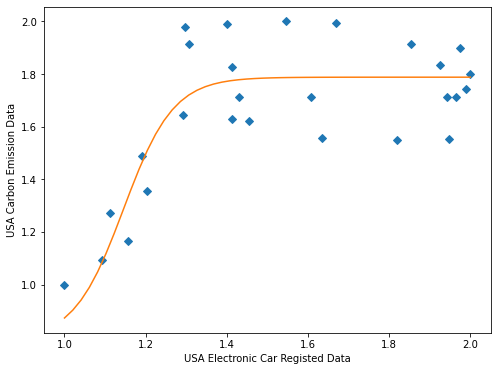

MSE in Percentage: 1.3804759343551534
R-squared: 0.7063471208067422


In [68]:

# generate initial parameter values
geneticParameters = generate_Initial_Parameters(xx,yy)
# curve fit the test data
usa_fittedParameters, pcov = curve_fit(func, xx, yy, geneticParameters)

##########################################################
ModelAndScatterPlot(usa_fittedParameters,8, 6,xx,yy,'USA Electronic Car Registed','USA Carbon Emission')
modelPredictions = func(xx, *usa_fittedParameters) 
MSPE = mean_squared_percentage_error(yy,modelPredictions) # Root Mean Squared Error, RMSE
absError = modelPredictions - yy
Rsquared = 1.0 - (np.var(absError) / np.var(yy))
print('MSE in Percentage:', MSPE)
print('R-squared:', Rsquared)


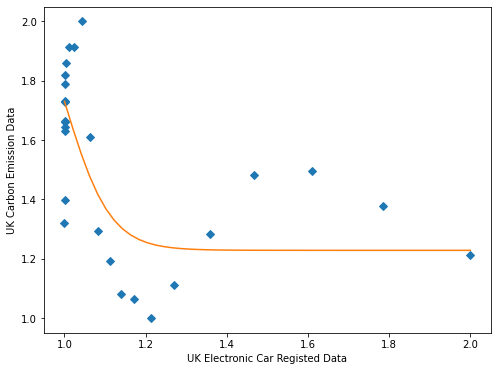

MSE in Percentage: 2.8557331982343177
R-squared: 0.5108852342555736


In [70]:
# generate initial parameter values
uk_geneticParameters = generate_Initial_Parameters(uk_E_car_dat_t,uk_emission_by_veh_t)
# curve fit the test data
uk_fittedParameters, pcov = curve_fit(func, uk_E_car_dat_t, uk_emission_by_veh_t, uk_geneticParameters)
ModelAndScatterPlot(uk_fittedParameters,8, 6,uk_E_car_dat_t,uk_emission_by_veh_t,'UK Electronic Car Registed','UK Carbon Emission')
UK_predictions = func(uk_E_car_dat_t, *uk_fittedParameters) 
UKMSPE = mean_squared_percentage_error(uk_emission_by_veh_t,UK_predictions) # Root Mean Squared Error, RMSE
UK_Rsquared = Rsqaured_test(UK_predictions,uk_emission_by_veh_t)
print('MSE in Percentage:', UKMSPE)
print('R-squared:', UK_Rsquared)